In [1]:
import jif
import numpy as np
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize roaster from YAML file

In [189]:
rstr = jif.Roaster("roaster.yaml")

In [190]:
pprint.pprint(rstr.config)

{'data': {'data_format': 'jif_segment',
          'epoch_num': -1,
          'filters': 'r',
          'segment_number': 0,
          'telescope': 'LSST'},
 'infiles': {'infile_1': 'output/roaster_model_image.h5'},
 'init': {'init_param_file': 'roaster_params.cfg', 'seed': 9216526},
 'metadata': {'outfile': '../output/TestData/roaster_out'},
 'model': {'achromatic': True,
           'galaxy_model_type': 'Spergel',
           'model_params': 'nu',
           'num_sources': 1},
 'run': {'debug': False, 'output_model': True, 'quiet': True},
 'sampling': {'nburn': 200,
              'nsamples': 500,
              'nthreads': 1,
              'nwalkers': 32,
              'sampler': 'emcee'}}


## Make the fake image data

In [197]:
images = rstr.render_model_images(nimages=1, nx=[80], ny=[80],
                                  tel_names=['LSST'], psfs=['model'], noise_var=2.e-7)

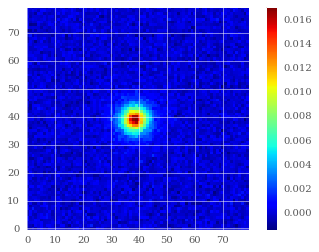

In [198]:
plt.imshow(images[0].array, interpolation='none', origin='lower')
plt.colorbar()

## Evaluate the image likelihood

In [199]:
rstr.model_paramnames

['nu']

In [200]:
nu = np.linspace(0.2, 0.8, 160)

lnp = np.array([rstr([nu_i]) for nu_i in nu])

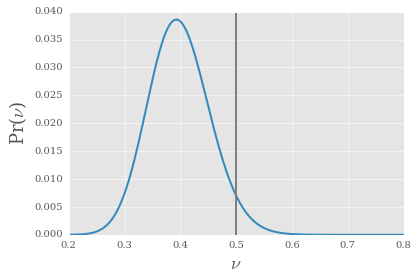

In [201]:
plt.plot(nu, np.exp(lnp - np.max(lnp)*0.999), color="#348ABD", alpha=1)
plt.axvline(0.5, color='grey')
plt.xlabel(r"$\nu$", fontsize=18)
plt.ylabel(r"Pr($\nu$)", fontsize=18)

## Loop the above sequence of operations over noise realizations

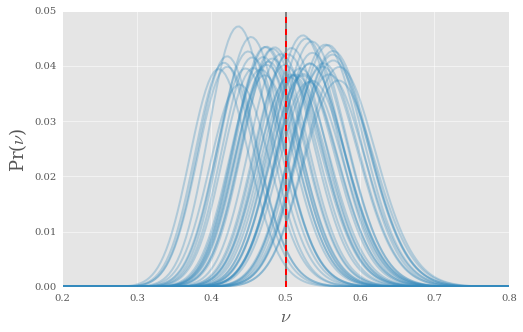

In [202]:
niter = 50
nu_ml = 0.0

fig = plt.figure(figsize=(8, 8/1.618))
for inoise in xrange(niter):
    images = rstr.render_model_images(nimages=1, nx=[80], ny=[80],
                                      tel_names=['LSST'], psfs=['model'], 
                                      noise_var=1.e-7)
    lnp = np.array([rstr([nu_i]) for nu_i in nu])
    nu_ml += nu[np.argmax(lnp)]
    plt.plot(nu, np.exp(lnp - np.max(lnp)*0.999), color="#348ABD", alpha=0.3)
nu_ml /= niter
plt.axvline(0.5, color='grey')
plt.axvline(nu_ml, color='red', linestyle='dashed')
plt.xlabel(r"$\nu$", fontsize=18)
plt.ylabel(r"Pr($\nu$)", fontsize=18)

## Input image from GREAT3-like simulation

In [11]:
from astropy.io import fits

iepoch = 0

In [12]:
f = fits.open("sim/control/ground/constant/epoch_catalog-000-0.fits")
sim_catalog = f[1].data

In [13]:
colnames = f[1].columns
f.close()
print colnames

ColDefs(
    name = 'num'; format = 'J'
    name = 'x'; format = 'D'
    name = 'y'; format = 'D'
    name = 'dx'; format = 'D'
    name = 'dy'; format = 'D'
    name = 'psf_e1'; format = 'D'
    name = 'psf_e2'; format = 'D'
    name = 'psf_fwhm'; format = 'D'
    name = 'g1'; format = 'D'
    name = 'g2'; format = 'D'
    name = 'gal_e1'; format = 'D'
    name = 'gal_e2'; format = 'D'
)


In [14]:
print colnames.__class__
print colnames.names

def colndx(colname):
    """
    Return the column index corresponding to the given name
    """
    return np.argwhere([x == colname for x in colnames.names])[0][0]
print colndx('gal_e1')

<class 'astropy.io.fits.column.ColDefs'>
['num', 'x', 'y', 'dx', 'dy', 'psf_e1', 'psf_e2', 'psf_fwhm', 'g1', 'g2', 'gal_e1', 'gal_e2']
10


In [15]:
sim_catalog[iepoch]

(0, 24.5, 24.5, -0.98060578946024179, -0.41024529468268156, 0.0, 0.0, 0.69999999999999996, 0.0014178461995583019, -0.041486870981251006, 0.0019704378462152999, -0.0030702104754297879)

### Load the data image

In [105]:
f = fits.open("sim/control/ground/constant/image-000-0.fits")
dat = f[0].data
f.close()

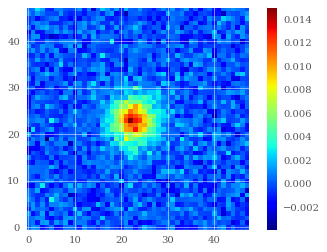

In [106]:
nx = 48
dat_seg = dat[(iepoch*nx):((iepoch+1)*nx), (iepoch*nx):((iepoch+1)*nx)]
plt.imshow(dat_seg, interpolation='none', origin='lower')
plt.colorbar()

### Mimic the Roaster 'Load' function

The Load() function is not flexible enough for this problem. So we mimic the load functionality here.

In [107]:
rstr_sb = jif.Roaster("sim/roaster_shear_bias_test.yaml")

In [108]:
pprint.pprint(rstr_sb.config)

{'data': {'data_format': 'jif_segment',
          'epoch_num': -1,
          'filters': 'r',
          'segment_number': 0,
          'telescope': 'LSST'},
 'infiles': {'infile_1': './sim/roaster_model_image.h5'},
 'init': {'init_param_file': 'sim/roaster_params_shear_bias_test.cfg',
          'seed': 9216526},
 'metadata': {'outfile': './sim/roaster_out'},
 'model': {'achromatic': True,
           'galaxy_model_type': 'Spergel',
           'model_params': 'nu hlr mag_sed1',
           'num_sources': 1},
 'run': {'debug': False, 'output_model': True, 'quiet': True},
 'sampling': {'nburn': 200,
              'nsamples': 500,
              'nthreads': 1,
              'nwalkers': 32,
              'sampler': 'emcee'}}


In [238]:
rstr_sb.pixel_data = [dat_seg]
# rstr_sb.pix_noise_var = [np.var(dat_seg[0:20, 0:20])]
rstr_sb.pix_noise_var = [1.e-6]
print "noise var: {:8.6g}".format(rstr_sb.pix_noise_var[0])

rstr_sb.num_epochs = 1
rstr_sb.nx = [nx]
rstr_sb.ny = [nx]
rstr_sb.filter_names = ['r']

rstr_sb._init_galaxy_models(nimages=1, tel_names=['LSST'], psfs=['model'])
rstr_sb.initialize_param_values(rstr_sb.config['init']['init_param_file'])

pixel_scale_arcsec = 0.2

g1 = sim_catalog[iepoch][colndx('g1')]
g2 = sim_catalog[iepoch][colndx('g2')]
kappa = 0.0
mu = 1. / ((1.-kappa)**2 - (g1**2 + g2**2))
print "magnification: {:8.6g}".format(mu)

rstr_sb.set_param_by_name('dx', sim_catalog[iepoch][colndx('dx')]*pixel_scale_arcsec)
rstr_sb.set_param_by_name('dy', sim_catalog[iepoch][colndx('dy')]*pixel_scale_arcsec)
rstr_sb.set_param_by_name('e1', sim_catalog[iepoch][colndx('gal_e1')] + g1)
rstr_sb.set_param_by_name('e2', sim_catalog[iepoch][colndx('gal_e2')] + g2)

hlr0 = 0.73 * mu
rstr_sb.set_param_by_name('hlr', hlr0)
print "HLR: {:8.6g}".format(hlr0)

# rstr_sb.set_param_by_name("mag_sed1", 40.32)

noise var:    1e-06
magnification:  1.00173
HLR:  0.73126


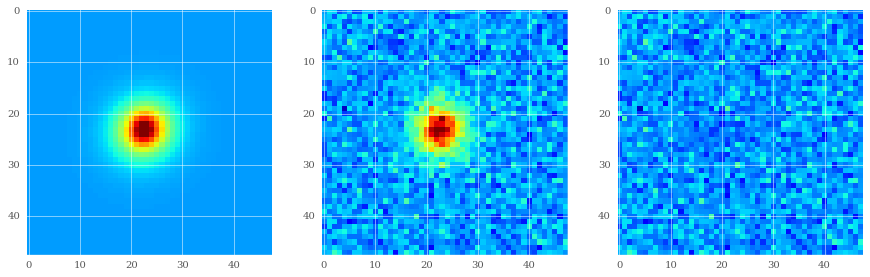

In [239]:
m = rstr_sb._get_model_image(iepochs=0)

vmin=-0.005
vmax=0.013

fig = plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.imshow(m.array, vmin=vmin, vmax=vmax, interpolation='none')
plt.subplot(1, 3, 2)
plt.imshow(rstr_sb.pixel_data[0], vmin=vmin, vmax=vmax, interpolation='none')
plt.subplot(1, 3, 3)
plt.imshow(rstr_sb.pixel_data[0] - m.array, vmin=vmin, vmax=vmax, interpolation='none')

In [240]:
m = np.linspace(40.2, 40.5, 300)
lnp = np.array([rstr_sb([0.5, hlr0, m_i]) for m_i in m])

m_ML = m[np.argmax(lnp)]
print "ML mag: {:8.6g}".format(m_ML)

ML mag:  40.3625


In [241]:
print m_ML / mu

40.2929902545


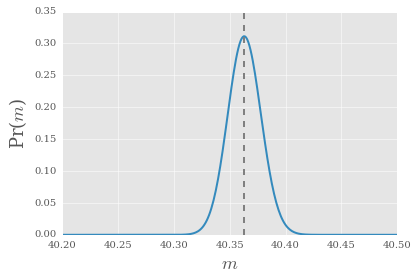

In [242]:
plt.plot(m, np.exp(lnp - np.max(lnp)*0.999), color="#348ABD", alpha=1)
plt.axvline(m_ML, color='grey', linestyle='dashed')
plt.xlabel(r"$m$", fontsize=18)
plt.ylabel(r"Pr($m$)", fontsize=18)

In [243]:
hlr = np.linspace(0.5, 1.4, 300)
lnp = np.array([rstr_sb([0.5, hlr_i, m_ML]) for hlr_i in hlr])

hlr_ML = hlr[np.argmax(lnp)]
print "ML hlr: {:8.6g}".format(hlr_ML)

ML hlr: 0.722742


### Check the 'nu' posterior

In [246]:
nu = np.linspace(0.0, 0.8, 300)

lnp = np.array([rstr_sb([nu_i, hlr0, m_ML]) for nu_i in nu])

nu_ML = nu[np.argmax(lnp)]
print "ML nu: {:8.6g}".format(nu_ML)

ML nu: 0.505686


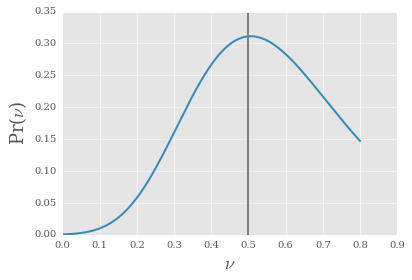

In [247]:
plt.plot(nu, np.exp(lnp - np.max(lnp)*0.999), color="#348ABD", alpha=1)
plt.axvline(0.5, color='grey')
plt.xlabel(r"$\nu$", fontsize=18)
plt.ylabel(r"Pr($\nu$)", fontsize=18)